# Introduction

This notebook finds the the point at which the ECMWF tempearture=0 deg C for each
radar pulse and overlays that on the reflectivity plot to check to see whether
the bright band occurs at the freezing level

#  Read in the height and reflectivity fields

In [19]:
from importlib import reload
import numpy as np
import datetime as dt
from datetime import timezone as tz
from matplotlib import pyplot as plt
import pyproj
from numpy import ma
import a301
from a301.cloudsat import get_geo
from pathlib import Path
from pyhdf.SD import SD, SDC
#
# new functions to read vdata and sds arrays
#
from a301.cloudsat import HDFvd_read, HDFsd_read


In [20]:
z_file= list(a301.data_dir.glob('*GEOPROF_GRANULE*hdf'))[0]
lats,lons,date_times,prof_times,dem_elevation=get_geo(z_file)
radar_reflectivity, radar_attrs = HDFsd_read(z_file,'Radar_Reflectivity')
radar_scale = radar_attrs['factor']
radar_missing = radar_attrs['missing']
radar_height, height_attrs = HDFsd_read(z_file,'Height')
meters2km=1.e3

# Now go get the ECMWF temperatures

Note that they have their own height vector EC_height

In [21]:
z_file= list(a301.data_dir.glob('*ECMWF-AUX_GRANULE*hdf'))[0]
ec_height=HDFvd_read(z_file,'EC_height')
ec_temps, temps_attributes = HDFsd_read(z_file,'Temperature')
ec_missing = temps_attributes['missing']

# Make a masked array of the reflectivity so that pcolormesh will plot it

note that I need to find the missing data before I divide by factor=100 to
convert from int16 to float

In [22]:
hit=(radar_reflectivity == radar_missing)
radar_reflectivity=radar_reflectivity.astype(np.float)
radar_reflectivity[hit]=np.nan
zvals = radar_reflectivity/radar_scale
zvals=ma.masked_invalid(zvals)

# Find the part of the orbing that corresponds to the 3 minutes containing the storm

You need to enter the start_hour and start_minute for the start time of your cyclone in the granule

In [23]:
first_time=date_times[0]
print(f'orbit start: {first_time}')
start_hour=3
start_minute=58
storm_start=starttime=dt.datetime(first_time.year,first_time.month,first_time.day,
                                        start_hour,start_minute,0,tzinfo=tz.utc)
#
# get 3 minutes of data from the storm_start
#
storm_stop=storm_start + dt.timedelta(minutes=3)
print(f'storm start: {storm_start}')
time_hit = np.logical_and(date_times > storm_start,date_times < storm_stop)
storm_lats = lats[time_hit]
storm_lons=lons[time_hit]
storm_prof_times=prof_times[time_hit]
storm_zvals=zvals[time_hit,:]
storm_height=radar_height[time_hit,:]
storm_date_times=date_times[time_hit]

orbit start: 2010-09-15 02:25:11.533000+00:00
storm start: 2010-09-15 03:58:00+00:00


# convert time to distance by using pyproj to get the greatcircle distance between shots

In [24]:
great_circle=pyproj.Geod(ellps='WGS84')
distance=[0]
start=(storm_lons[0],storm_lats[0])
for index in np.arange(1,len(storm_lons)):
    azi12,azi21,step= great_circle.inv(storm_lons[index-1],storm_lats[index-1],
                                       storm_lons[index],storm_lats[index])
    distance.append(distance[index-1] + step)
distance=np.array(distance)/meters2km

# Make the plot assuming that height is the same for every shot

i.e. assume that height[0,:] = height[1,:] = ...

in reality, the bin heights are depend on the details of the radar returns, so
we would need to historgram the heights into a uniform set of bins -- ignore that for this qualitative picture

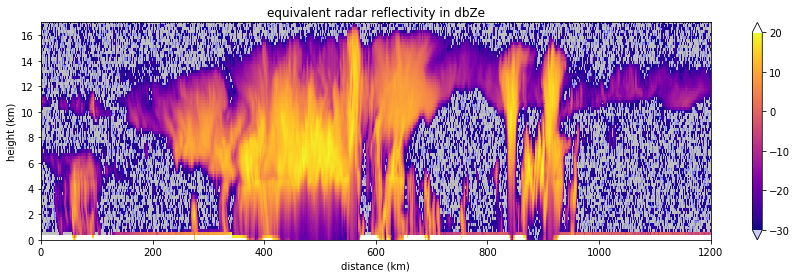

In [25]:
%matplotlib inline
fig,ax=plt.subplots(1,1,figsize=(15,4))

from matplotlib import cm
from matplotlib.colors import Normalize
vmin=-30
vmax=20
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
cmap_ref=cm.plasma
cmap_ref.set_over('w')
cmap_ref.set_under('b',alpha=0.2)
cmap_ref.set_bad('0.75') #75% grey

def plot_field(distance,height,field,ax,cmap=None,norm=None):
    """
    given an axis, draw a cloudsat cross section
    """
    if cmap is None:
        cmap=cm.inferno
    col=ax.pcolormesh(distance,height,field,cmap=cmap,
                  norm=the_norm)
    ax.figure.colorbar(col,extend='both',ax=ax)
    return ax

cloud_height_km=radar_height[0,:]/meters2km
ax=plot_field(distance,cloud_height_km,storm_zvals.T,ax,cmap=cmap_ref,
              norm=the_norm)
ax.set(ylim=[0,17],xlim=(0,1200))
ax.set(xlabel='distance (km)',ylabel='height (km)',
       title='equivalent radar reflectivity in dbZe')
fig.savefig('cloudsat.png')    

# Now subset the ECMWF data

In [26]:
bad_temps = (ec_temps == ec_missing)
ec_temps[bad_temps]=np.nan
ec_temps=np.ma.masked_invalid(ec_temps)
ec_temps = ec_temps - 273.15
ec_temps=ec_temps[time_hit,:]

### ECMWF temperatures for the segment

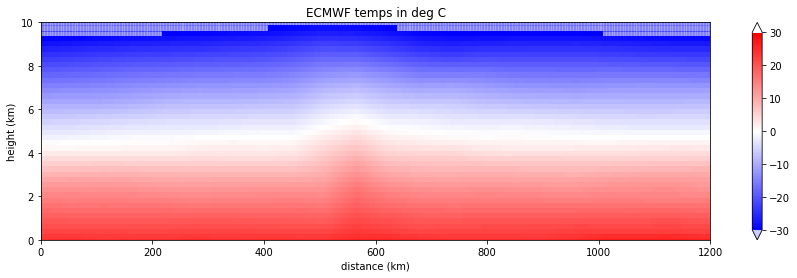

In [30]:
fig, ax =plt.subplots(1,1,figsize=(15,4))
vmin=-30
vmax=30
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
cmap_ec= cm.bwr
cmap_ec.set_over('w')
cmap_ec.set_under('b',alpha=0.2)
cmap_ec.set_bad('0.75') #75% grey

ec_height_km=ec_height/meters2km
ax=plot_field(distance,ec_height_km,ec_temps.T,ax,cmap=cmap_ec,
                  norm=the_norm)
ax.set(ylim=[0,10],xlim=(0,1200))
ax.set(xlabel='distance (km)',ylabel='height (km)',title='ECMWF temps in deg C')
fig.savefig('temps.png')

# Problem -- your task

In the cell below, calculate a vector or list called height_vec that has the same length
as your segment (1125 time values in my case).  Each of the values should be the
height at which the ECWMF temperatures cross the 0 deg C isotherm. My code does this in
two steps:

1. use numpy.abs to make every temperature positive
2. use numpy.argmin to find the index of the lowest positive temperature, which
   should be the index closest to zero
3. use that index to look up the height in ec_height_km
4. save that height in height_vec

In [28]:
#
# Use this cell to calculate height_vec
#
# YOUR CODE HERE
vec1=np.abs(ec_temps)

# height_vec=np.zeros(1125)
height_vec_list=[]

for col in vec1[:,0:124]:
    min_height=np.argmin(col)
    height_vec_list.append(ec_height_km[min_height][0])


# Now plot height_vec on top of cloudsat zvals

NameError: name 'height_vec' is not defined

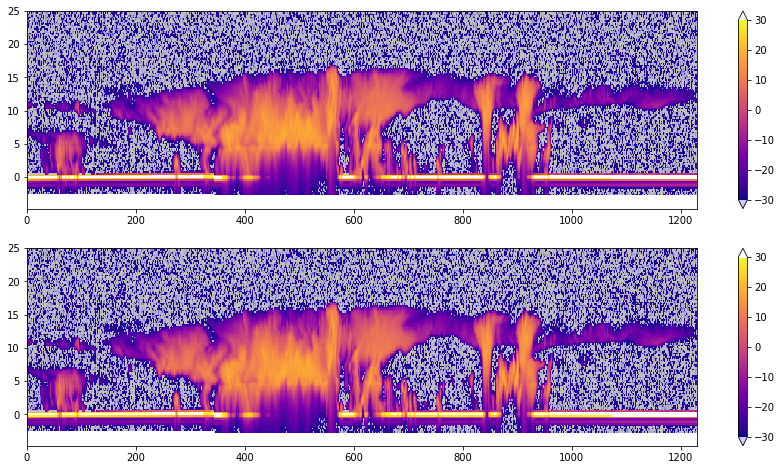

In [29]:
fig, (ax1,ax2) =plt.subplots(2,1,figsize=(15,8))
ax1=plot_field(distance,cloud_height_km,storm_zvals.T,ax1,cmap_ref)
ax2=plot_field(distance,cloud_height_km,storm_zvals.T,ax2,cmap_ref)
ax2.plot(distance,height_vec,'ro')
#
# we can loop over axes to set limits, labels
#
[ax.set(xlim=(0,1200),ylim=(0,17),xlabel='distance (km)',
        ylabel='height (km)') for ax in [ax1,ax2]]
fig.savefig('cloudsat_heights.png',dpi=200)